In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets

In [16]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
1


In [17]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [18]:
trainset = datasets.MNIST(root='/scratch/yardima/data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = datasets.MNIST(root='/scratch/yardima/data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=False, num_workers=2)

tensor([1, 1, 4, 9, 7, 8, 5, 5, 5, 3, 1, 4, 0, 9, 2, 9, 3, 1, 3, 7, 7, 7, 4, 7,
        0, 9, 9, 3, 1, 8, 4, 7])


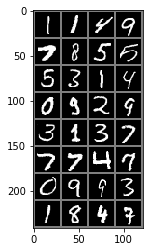

In [19]:
dataiter = iter(trainloader)
i, l = dataiter.next()

g = torchvision.utils.make_grid(i, nrow=4)

g = g / 2 + 0.5     # unnormalize
npimg = g.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

print(l)

## Test metric learning/CNN

In [20]:
class CNN(nn.Module):
    
    def __init__(self, *, embed_dim):
        super(CNN, self).__init__()
        
        self.c1 = nn.Conv2d(1, 16, kernel_size=5)
        self.c2 = nn.Conv2d(16, 32, kernel_size=5)
        self.c3 = nn.Conv2d(32, 16, kernel_size=5)
        self.c4 = nn.Conv2d(16, 16, kernel_size=5)
        self.c5 = nn.Conv2d(16, embed_dim, kernel_size=12)
        
        self.EMBED_DIM = embed_dim
    
    def forward(self, x):
        
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = F.relu(self.c4(x))
        x = self.c5(x)
        
        x = x.view(-1, self.EMBED_DIM)
        
        return x

In [21]:
cnn = CNN(embed_dim=10)

## print number of parameters in network:
pcount = 0
for p in cnn.parameters():
    pcount += p.numel()
    
print("Total trainable parameter count: {}".format(pcount))

Total trainable parameter count: 55530


## Prepare dataset for triplet loss

In [22]:
classindices = []
trainy = trainset.train_labels.data.numpy()
for i in range(10):
    classindices.append(np.nonzero(trainy == i)[0])

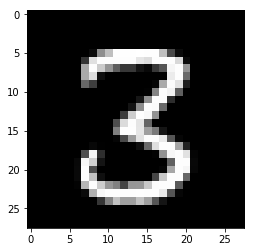

In [23]:
sample = trainset[classindices[3][447]][0]
g = torchvision.utils.make_grid(sample, nrow=1)

g = g / 2 + 0.5     # unnormalize
npimg = g.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [24]:
def gen_triplet(dataset, classindices, n_samples):
    X = []
    y = []
    for i in range(n_samples):
        c = np.random.choice(10, size=2, replace=False)
        
        p_samples = np.random.choice(classindices[c[0]], size=2, replace=False)
        n_sample = np.random.choice(classindices[c[1]], size=1)
        
        X.append(dataset[p_samples[0]][0])
        X.append(dataset[p_samples[1]][0])
        X.append(dataset[n_sample[0]][0])
        
        y.append(dataset[p_samples[0]][1])
        y.append(dataset[p_samples[1]][1])
        y.append(dataset[n_sample[0]][1])
        
    return (torch.stack(X), 
            torch.stack(y))

## Train model with different hyper-parameters

In [ ]:
def triplet_loss(loss_fun, output, n_samples, target, reg):
    ix = np.arange(n_samples, dtype=np.int32) * 3
    
    distp = (output[ix] - output[ix + 1]).pow(2).sum(dim=1)
    distn = (output[ix] - output[ix + 2]).pow(2).sum(dim=1)
    
    norm_loss = output.pow(2).sum() / n_samples
    loss_dist = loss_fun(distn, distp, target) / n_samples
    
    return reg * norm_loss + loss_dist

In [ ]:
cnn = CNN(embed_dim=10)
optimizer = optim.SGD(cnn.parameters(), lr = 1e-3, momentum=0.9)
lr_update = lambda epoch: 0.9 ** epoch
cnn = cnn.to(device)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_update)

In [ ]:
%%time
reg = 3e-3
margin = 1
loss_fun = nn.MarginRankingLoss(margin=margin)
n_samples = 3

epoch_size = 10000

for e in range(100):
    running_loss = 0.
    scheduler.step()
    
    for i in range(1, 10000):
        x, label = gen_triplet(trainset, classindices, n_samples)
        x = x.to(device)
        target = torch.FloatTensor(n_samples).fill_(1).to(device)
        
        optimizer.zero_grad()
        out = cnn.forward(x)
        loss = triplet_loss(loss_fun, out, n_samples, target, reg)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 1250 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i, running_loss / 1250))
            running_loss = 0.

[1,  1250] loss: 0.237
[1,  2500] loss: 0.087
[1,  3750] loss: 0.059
[1,  5000] loss: 0.046
[1,  6250] loss: 0.039
[1,  7500] loss: 0.035
[1,  8750] loss: 0.035
[2,  1250] loss: 0.030
[2,  2500] loss: 0.028
[2,  3750] loss: 0.026
[2,  5000] loss: 0.026
[2,  6250] loss: 0.027
[2,  7500] loss: 0.026
[2,  8750] loss: 0.024
[3,  1250] loss: 0.022
[3,  2500] loss: 0.024


In [ ]:
torch.save(cnn, '/home/yardima/Python/models/model1')

## Evaluate model